In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation
import PIL
from PIL import Image
import random
import os



In [2]:
random.seed(0)
data_main = pd.read_csv('data_labels_mainData.csv')
data_main.drop(columns=["InstanceID", "patientID"])
data_extra = pd.read_csv('data_labels_extraData.csv')
data_extra.drop(columns=["InstanceID", "patientID"])


,ImageName,isCancerous
0,12681.png,0
1,12682.png,0
2,12683.png,0
3,12684.png,0
4,12685.png,0
...,...,...
10379,20028.png,0
10380,20029.png,0
10381,20030.png,0
10382,20031.png,0


Main Data Shape: (9896, 6)
Extra Data Shape: (10384, 4)
Common Columns: 
      InstanceID
      patientID
      ImageName
      isCancerous
Unique Main Columns: 
      cellType
      cellTypeName
Null Main Data: InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64
Duplicated Main Data: 0
Images Duplicated:  0
Value counts for Iscancerous
isCancerous
0    5817
1    4079
Name: count, dtype: int64
Percent size: 
0: 58.78132578819725
1: 41.21867421180275


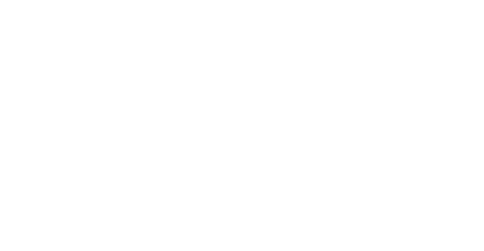

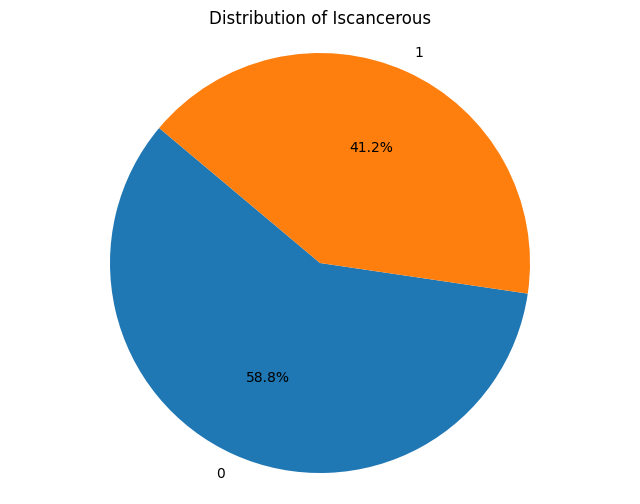

Value counts for Celltypename
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64
Percent size: 
Epithelial: 41.21867421180275
Inflammatory: 25.697251414713012
Fibroblast: 19.078415521422798
Others: 14.005658852061439


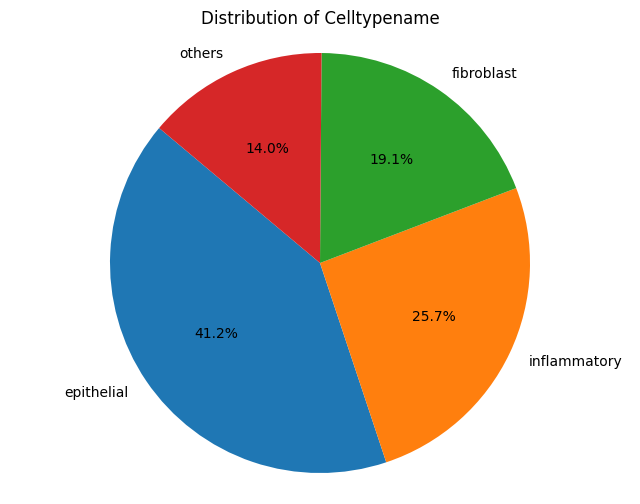

isCancerous,0,1
cellTypeName,,
epithelial,0,4079
fibroblast,1888,0
inflammatory,2543,0
others,1386,0


In [3]:
#EDA
fig, ax = plt.subplots(figsize=(6,3))
ax.axis("off")

#Structure and Size
print("Main Data Shape: " + str(data_main.shape))
print("Extra Data Shape: " + str(data_extra.shape))
print("Common Columns: ")

for column in data_main.columns.intersection(data_extra.columns):
    print("      "+ column)
print("Unique Main Columns: ")
for column in data_main.columns.symmetric_difference(data_extra.columns):
    print("      "+ column)

print("Null Main Data: " + str(data_main.isnull().sum()))
print("Duplicated Main Data: " + str(data_main.duplicated().sum()))
print("Images Duplicated:  " + str(data_main["ImageName"].duplicated().sum()))

#Value Counts
relevantColumns = ["isCancerous", "cellTypeName"]
for col in relevantColumns:
    print(f"Value counts for " + col.capitalize())
    value_counts = data_main[col].value_counts()
    print(value_counts)
    print("Percent size: " )
    
    for value, amount in data_main[col].value_counts().items():
        print(str(value).capitalize() + ": " + str((amount/len(data_main[col]))*100))
    
    plt.figure(figsize=(8, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of {col.capitalize()}")
    plt.axis('equal')  
    plt.show()

pd.crosstab(data_main["cellTypeName"], data_main["isCancerous"])

4079
{0: 'fibroblast', 1: 'inflammatory', 2: 'epithelial', 3: 'others'}


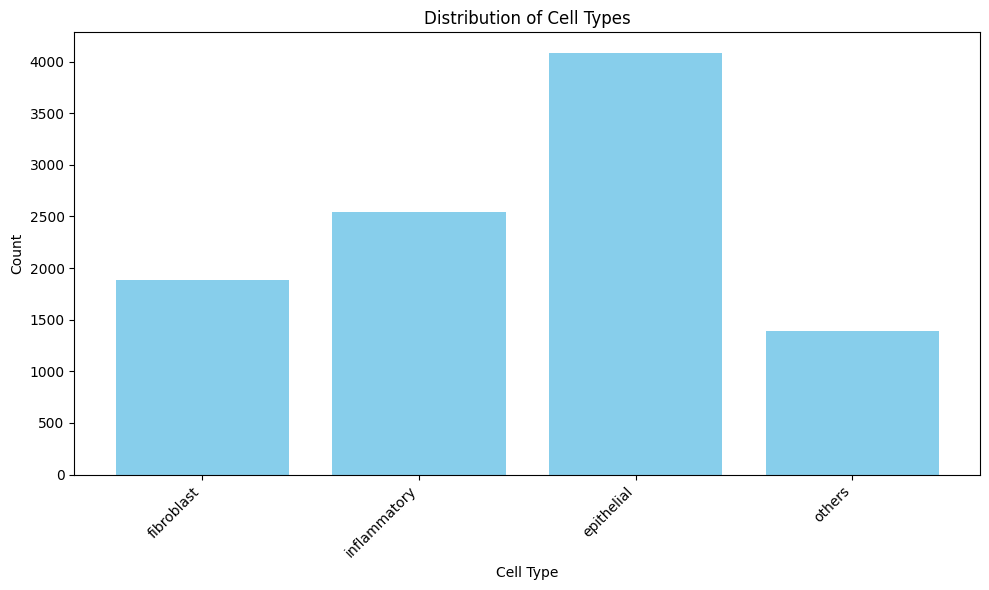

4079
4079
4079
4079


FileNotFoundError: [WinError 3] The system cannot find the path specified: './patch_images/augmented_images/epithelial/'

In [4]:
data_cancer = data_main.drop(columns=["cellTypeName", "cellType"])
data_cancer = pd.concat([data_cancer, data_extra])

IMG_SIZE = 27
cell_type_counts = data_main["cellType"].value_counts().sort_index()
max_value = cell_type_counts.max()
print(max_value)

cell_type_mapping = data_main.drop_duplicates(subset=["cellType"])[["cellType", "cellTypeName"]].sort_values("cellType")
cell_type_names = cell_type_mapping["cellTypeName"].values
cell_type_dict = dict(zip(cell_type_mapping["cellType"], cell_type_mapping["cellTypeName"]))
print(cell_type_dict)
plt.figure(figsize=(10, 6))
plt.bar(cell_type_names, cell_type_counts.values, color='skyblue')
plt.xlabel("Cell Type")
plt.ylabel("Count")
plt.title("Distribution of Cell Types")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

cellType0Images = data_main[data_main["cellType"] == 0]["ImageName"].values
cellType1Images = data_main[data_main["cellType"] == 1]["ImageName"].values
cellType2Images = data_main[data_main["cellType"] == 2]["ImageName"].values
cellType3Images = data_main[data_main["cellType"] == 3]["ImageName"].values

imageCollections = []
imageCollections.append(cellType0Images)
imageCollections.append(cellType1Images)
imageCollections.append(cellType2Images)
imageCollections.append(cellType3Images)

data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
data_type_with_augmentation = data_type.copy()
for i in range(0, len(cell_type_dict)):
    dir = "./patch_images/"
    augDir = dir + "augmented_images/" + cell_type_dict[i] + "/"
    existing_aug = [name for name in os.listdir(augDir) if os.path.isfile(os.path.join(augDir, name))]
    print(len(existing_aug) + len(imageCollections[i]))
    print(max_value)
    if not len(existing_aug) + len(imageCollections[i]) >= max_value:
        augmented_df = AugmentData(imageCollections[i], max_value, data_type, i, cell_type_dict[i])
        data_type_with_augmentation = pd.concat([data_type_with_augmentation, augmented_df], ignore_index=True)


In [5]:

def AugmentData(imageNames ,maxCount, originalDF, label, labelName):
    
    counter = len(imageNames)

    augmentedRows = []
    
    dir = "./patch_images/"
    augDir = dir + "augmented_images/" + labelName + "/"
    existing_aug = [name for name in os.listdir(augDir) if os.path.isfile(os.path.join(augDir, name))]
    existing_aug_count = len(existing_aug)
    counter += existing_aug_count
    print("Number of Files Detected: " + str(counter) + "Max Count: " + str(maxCount))
    if(counter >= maxCount):
        return

    # #Empty the directory
    # for fileName in os.listdir(augDir):
    #     file_path = os.path.join(augDir, fileName)
    #     if(os.path.isfile(file_path)):
    #         os.remove(file_path)

    
    while counter < maxCount:
        counter += 1
        #Pick and random image and open
        chosenImage = imageNames[random.randint(0, len(imageNames)-1)]
        openedImage = PIL.Image.open(dir + chosenImage).convert("RGB")
       
        #convert to data 
        image_np = np.array(openedImage)
        image_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
        image_tensor = tf.expand_dims(image_tensor, 0)  # Add batch dimension
        
        data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        ])
        augmented_tensor = data_augmentation(image_tensor)
        augmented_image = tf.cast(tf.squeeze(augmented_tensor), tf.uint8).numpy()
        augmented_pil = PIL.Image.fromarray(augmented_image)

        augmentedImageName = "Augmented" + str(counter) +".png"
        save_path = os.path.join(augDir + augmentedImageName)
        augmented_pil.save(save_path)
        new_row = {"ImageName": augmentedImageName, "cellType": label, "cellTypeName": labelName}
        augmentedRows.append(new_row)
    
    return pd.DataFrame(augmentedRows)

In [6]:
train_data_cancer, test_data_cancer = train_test_split(data_cancer, test_size=0.2, random_state=42)
train_data_cancer, val_data_cancer = train_test_split(train_data_cancer, test_size=0.25, random_state=42)

In [7]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,642 (2.14 MB)

 Trainable params: 560,642 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [10]:
train_data_cancer['isCancerous'] = train_data_cancer['isCancerous'].astype('str')
val_data_cancer['isCancerous'] = val_data_cancer['isCancerous'].astype('str')

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=5, verbose=1, mode='max', restore_best_weights=True)

In [15]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.8411 - loss: 0.3651 - val_categorical_accuracy: 0.8462 - val_loss: 0.3505
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8403 - loss: 0.3557 - val_categorical_accuracy: 0.8311 - val_loss: 0.3768
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.8407 - loss: 0.3575 - val_categorical_accuracy: 0.8368 - val_loss: 0.3726
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.8456 - loss: 0.3505 - val_categorical_accuracy: 0.8484 - val_loss: 0.3472
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8414 - loss: 0.3581 - val_categorical_accuracy: 0.8521 - val_loss: 0.3435
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - categorical_accuracy: 0.8433 - loss: 0.3495 - val_categorical_accuracy: 0.8481 - val_loss: 0.3454
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8459 -

Early stopping is triggered at epoch 10 with the best weights being found at epoch 7 meaning running it for longer either will make results worse or have no impact

In [16]:
def plot_learning_curve(title, train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

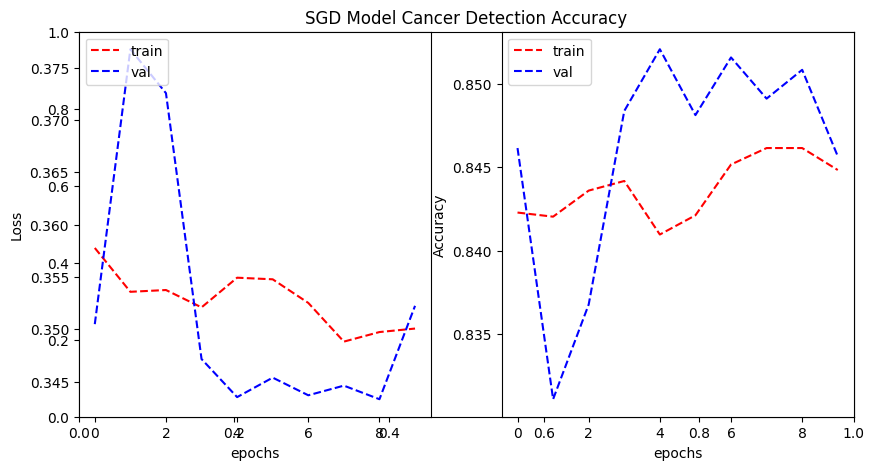

In [17]:
plot_learning_curve("SGD Model Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [18]:
test_data_cancer['isCancerous'] = test_data_cancer['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


In [19]:
model.evaluate(test_generator)

 140/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - categorical_accuracy: 0.9229 - loss: 0.2622

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 952us/step - categorical_accuracy: 0.8575 - loss: 0.3296


[0.34482330083847046, 0.8498520851135254]

In [20]:
#Classification
data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
print(data_type)

      InstanceID  patientID  ImageName  cellType
0          22405          1  22405.png         0
1          22406          1  22406.png         0
2          22407          1  22407.png         0
3          22408          1  22408.png         0
4          22409          1  22409.png         0
...          ...        ...        ...       ...
9891        1625         60   1625.png         2
9892        1626         60   1626.png         2
9893        1627         60   1627.png         2
9894        1628         60   1628.png         2
9895        1629         60   1629.png         2

[9896 rows x 4 columns]


In [21]:
train_data_type, test_data_type = train_test_split(data_type, test_size=0.2, random_state=42)
train_data_type, val_data_type = train_test_split(train_data_type, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_type.shape[0], val_data_type.shape[0], test_data_type.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [22]:
train_data_type['cellType'] = train_data_type['cellType'].astype('str')
val_data_type['cellType'] = val_data_type['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [23]:
model_VGG_1_relu = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_sigmoid = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_softmax = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(4),
])

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model_VGG_1_relu.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_sigmoid.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_softmax.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [25]:
history_VGG_1_relu = model_VGG_1_relu.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)
history_VGG_1_sigmoid = model_VGG_1_sigmoid.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)
history_VGG_1_softmax = model_VGG_1_softmax.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - categorical_accuracy: 0.4835 - loss: 1.1790 - val_categorical_accuracy: 0.6094 - val_loss: 0.9979
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6732 - loss: 0.8262 - val_categorical_accuracy: 0.6806 - val_loss: 0.7946
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7258 - loss: 0.7005 - val_categorical_accuracy: 0.6897 - val_loss: 0.7977
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.7147 - loss: 0.7325 - val_categorical_accuracy: 0.7281 - val_loss: 0.6754
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7324 - loss: 0.6827 - val_categorical_accuracy: 0.7575 - val_loss: 0.6407
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.7677 - loss: 0.6095 - val_categorical_accuracy: 0.7418 - val_loss: 0.6870
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.7661 - loss: 0

In [26]:
test_data_type['cellType'] = test_data_type['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_type,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


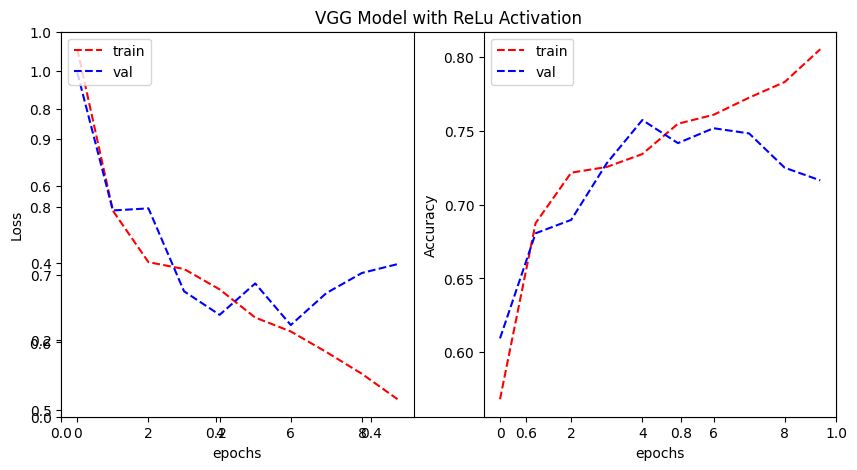

  77/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.6273 - loss: 0.8051

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - categorical_accuracy: 0.7374 - loss: 0.6833


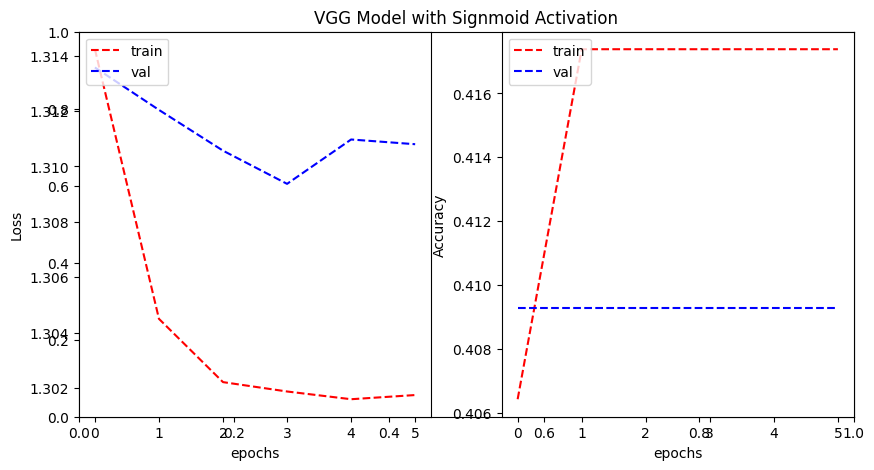

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - categorical_accuracy: 0.3773 - loss: 1.3481


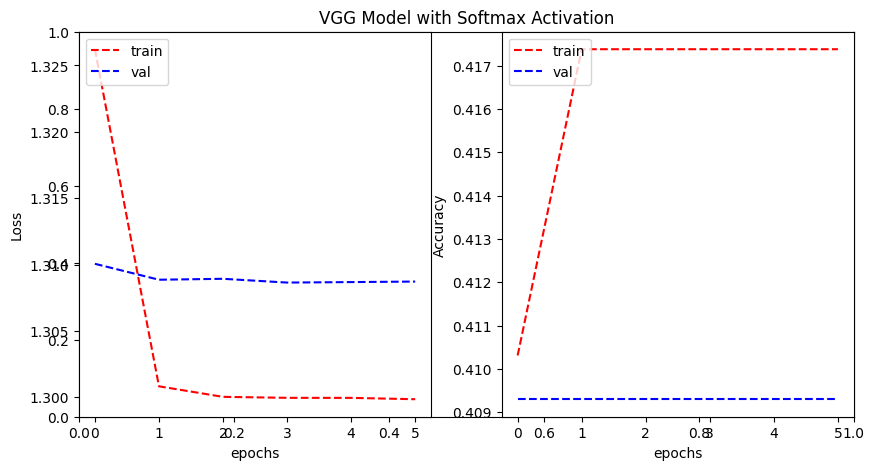

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - categorical_accuracy: 0.3953 - loss: 1.3262


[1.3215819597244263, 0.3994949460029602]

In [27]:
plot_learning_curve("VGG Model with ReLu Activation",history_VGG_1_relu.history['loss'], history_VGG_1_relu.history['val_loss'], 
                    history_VGG_1_relu.history['categorical_accuracy'], history_VGG_1_relu.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_relu.evaluate(test_generator)
plot_learning_curve("VGG Model with Signmoid Activation",history_VGG_1_sigmoid.history['loss'], history_VGG_1_sigmoid.history['val_loss'], 
                    history_VGG_1_sigmoid.history['categorical_accuracy'], history_VGG_1_sigmoid.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_sigmoid.evaluate(test_generator)

plot_learning_curve("VGG Model with Softmax Activation",history_VGG_1_softmax.history['loss'], history_VGG_1_softmax.history['val_loss'], 
                    history_VGG_1_softmax.history['categorical_accuracy'], history_VGG_1_softmax.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_softmax.evaluate(test_generator)


This shows a significant amount of overfitting, due to the model learning valuing irrelevant features like noise resulting in worse performance with new data

In [28]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    # preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(0.2),
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4),
])

model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - categorical_accuracy: 0.5289 - loss: 1.2022 - val_categorical_accuracy: 0.6887 - val_loss: 0.8469
Epoch 2/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6819 - loss: 0.8824 - val_categorical_accuracy: 0.7059 - val_loss: 0.8130
Epoch 3/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7052 - loss: 0.8101 - val_categorical_accuracy: 0.6544 - val_loss: 0.8648
Epoch 4/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.7281 - loss: 0.7863 - val_categorical_accuracy: 0.7110 - val_loss: 0.8265
Epoch 5/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.7319 - loss: 0.7590 - val_categorical_accuracy: 0.7216 - val_loss: 0.7648
Epoch 6/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.7313 - loss: 0.7552 - val_categorical_accuracy: 0.7383 - val_loss: 0.7031
Epoch 7/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.735

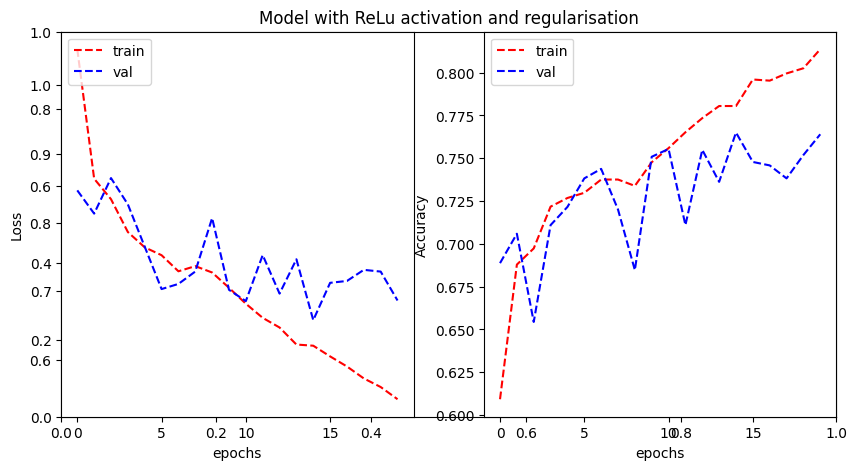

In [29]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=25, callbacks=earlyStop, verbose=1)

plot_learning_curve("Model with ReLu activation and regularisation", history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Significantly better results just with regularization, will try to fit better later

In [30]:
#Using extra data to  improve the cell type classification
extra_data_for_type = data_extra[["InstanceID", "patientID", "ImageName"]]

def preprocess_image(filename, img_dir="./patch_images/"):
    path = os.path.join(img_dir, filename)
    image = Image.open(path).convert("RGB")
    image = image.resize((27, 27))
    image_array = np.array(image).astype(np.float32) / 255.0
    return image_array

X_extra = np.array([
    preprocess_image(name) for name in extra_data_for_type["ImageName"]
])

predictions = model_VGG_2.predict(X_extra)
predicted_classes = np.argmax(predictions, axis=1)

label_dict = {0: 'fibroblast', 1: 'lymphocyte', 2: 'neutrophil', 3: 'monocyte'}
predicted_labels = [label_dict[i] for i in predicted_classes]

extra_data_for_type["predicted_cellType"] = predicted_labels

extra_data_for_type.to_csv("extra_data_with_predictions.csv", index=False)

325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
